<h1 style="text-align:center;font-size:30px;" > Quora Question Pair Similarity </h1>

# Part 4 : Improving Model Performance

## 1. Model Evaluation using TFIDF Vectorization

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
from tqdm import tqdm
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
import spacy
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from prettytable import PrettyTable

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve
from sklearn.svm import LinearSVC

In [149]:
#nlp_features_train.csv (NLP Features)
if os.path.isfile('nlp_features_train.csv'):
    dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
else:
    print("download nlp_features_train.csv from drive or run previous notebook")

#prepro_features_train.csv (Simple Preprocessing Feartures)
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    print("download df_fe_without_preprocessing_train.csv from drive or run previous notebook")

#train.csv preprocessed question1 & question2
if os.path.isfile('train.csv'):
    dfques = pd.read_csv("train.csv",encoding='latin-1')
    dfques['question1'] = dfques['question1'].apply(lambda x: str(x))
    dfques['question2'] = dfques['question2'].apply(lambda x: str(x))
else:
    print("download train.csv from drive or run previous notebook")

In [150]:
df1 = dfnlp.drop(['qid1','qid2','question1','question2'],axis=1)
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3 = dfques.drop(['qid1','qid2','is_duplicate'], axis=1)

df_temp  = df1.merge(df2, on='id',how='left')

# df_final contains Simple features, NLP features & Preprocessed Questions
df_final = df_temp.merge(df3, on='id', how='left')

In [151]:
df_final.shape

(404290, 30)

In [152]:
# dropping the is_duplicate feature from df_final
y = df_final['is_duplicate']
df = df_final.drop(['is_duplicate'],axis=1)

In [59]:
# shape of df after dropping is_duplicate
df.shape

(404290, 29)

In [7]:
# splitting the dataset into train (70%) & test (30%)
X_train,X_test, y_train, y_test = train_test_split(df, y, test_size=0.3)

In [8]:
# computing the TFIDF vectors for question1 & question2 for train data
x_train_ques1 = list(X_train['question1'])
x_train_ques2 = list(X_train['question2'])

tfidf = TfidfVectorizer(lowercase=False, max_features=50000)
vec1 = tfidf.fit_transform(x_train_ques1)
vec2 = tfidf.fit_transform(x_train_ques2)
print(vec1.shape)
print(vec2.shape)

(283003, 50000)
(283003, 50000)


In [9]:
# computing the TFIDF vectors for question1 & question2 for test data
x_test_ques1 = list(X_test['question1'])
x_test_ques2 = list(X_test['question2'])

vec3 = tfidf.transform(x_test_ques1)
vec4 = tfidf.transform(x_test_ques2)
print(vec3.shape)
print(vec4.shape)

(121287, 50000)
(121287, 50000)


In [10]:
# dropping the question1 & question2 columns from train & test data
X_train = X_train.drop(['question1', 'question2'],axis=1)
X_test = X_test.drop(['question1', 'question2'], axis=1)

In [11]:
# shape of the dataset after dropping question1 & question2
print(X_train.shape)
print(X_test.shape)

(283003, 27)
(121287, 27)


In [12]:
# horizontally stacking the TFIDF vectors of question1 & question2 for train data
sc_train = hstack((vec1, vec2))

In [13]:
# horizontally stacking the TFIDF vectors of question1 & question2 for test data
sc_test = hstack((vec3, vec4))

In [14]:
sc_train_final = hstack((sc_train, X_train))
sc_test_final = hstack((sc_test, X_test))

In [15]:
sc_train_final = sc_train_final.tocsr()
sc_test_final = sc_test_final.tocsr()

In [16]:
print(sc_train_final.shape)
print(sc_test_final.shape)

(283003, 100027)
(121287, 100027)


In [17]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    plt.show()

## Logistic Regression

For values of C =  1e-05 The log loss is: 0.4760294278692292
For values of C =  0.0001 The log loss is: 0.45239478560601637
For values of C =  0.001 The log loss is: 0.4351643544976169
For values of C =  0.01 The log loss is: 0.41596801181450643
For values of C =  0.1 The log loss is: 0.4025565259422532
For values of C =  1 The log loss is: 0.4039944960160513
For values of C =  10 The log loss is: 0.3991583848913962


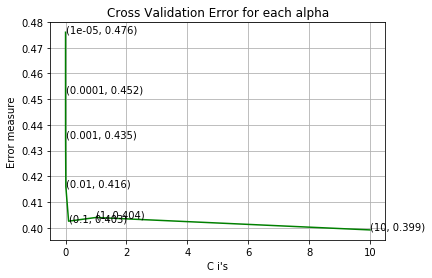

For values of best C =  10 The train log loss is: 0.3836730420986669
For values of best C =  10 The test log loss is: 0.3991583848913962
Total number of data points : 121287


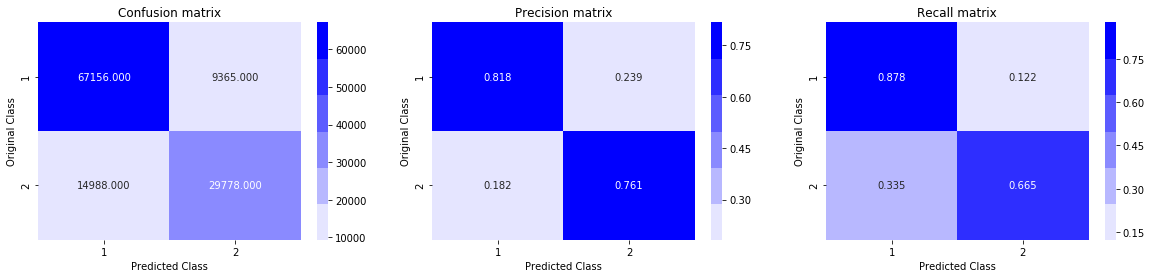

In [21]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.metrics import confusion_matrix
import seaborn as sns

C = [10 ** x for x in range(-5, 2)] # hyperparam for LR classifier.


log_error_array=[]
for i in C:
    clf = LogisticRegression(C=i, penalty='l2', class_weight='balanced', random_state=42)
    clf.fit(sc_train_final, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(sc_train_final, y_train)
    predict_y = sig_clf.predict_proba(sc_test_final)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of C = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(C, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((C[i],np.round(txt,3)), (C[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("C i's")
plt.ylabel("Error measure")
plt.show()


best_C = np.argmin(log_error_array)
clf = LogisticRegression(C=C[best_C], penalty='l2', class_weight='balanced', random_state=42)
clf.fit(sc_train_final, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(sc_train_final, y_train)

predict_y = sig_clf.predict_proba(sc_train_final)
print('For values of best C = ', C[best_C], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(sc_test_final)
print('For values of best C = ', C[best_C], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)a
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

## Linear SVM

For values of C =  1e-05 The log loss is: 0.5387252000469968
For values of C =  0.0001 The log loss is: 0.503169700555303
For values of C =  0.001 The log loss is: 0.5541077612998483
For values of C =  0.01 The log loss is: 0.5014601374437659
For values of C =  0.1 The log loss is: 0.4960820323948534
For values of C =  1 The log loss is: 0.4960820323948534
For values of C =  10 The log loss is: 0.4960820323948534


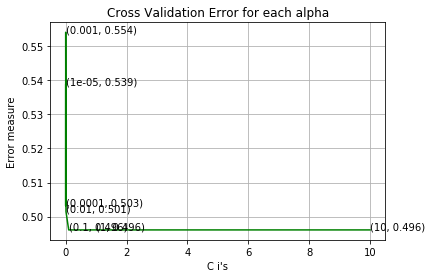

For values of best C =  0.1 The train log loss is: 0.49572974514432044
For values of best C =  0.1 The test log loss is: 0.4960820323948534
Total number of data points : 121287


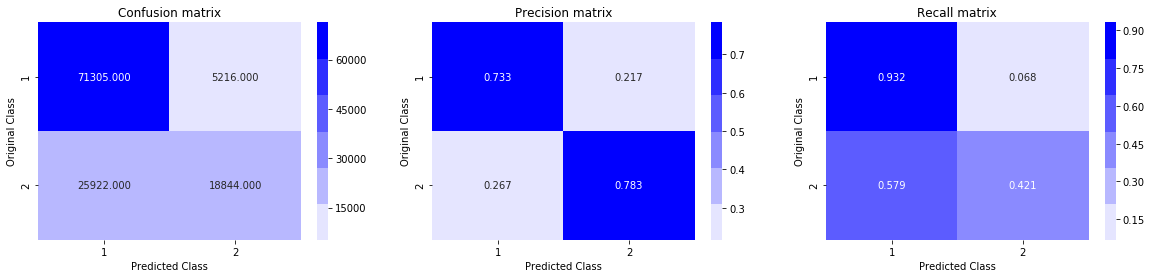

In [28]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.metrics import confusion_matrix
import seaborn as sns

C = [10 ** x for x in range(-5, 2)] # hyperparam


log_error_array=[]
for i in C:
    clf = LinearSVC(C=i, penalty='l2', loss='hinge', class_weight='balanced', random_state=42)
    clf.fit(sc_train_final, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(sc_train_final, y_train)
    predict_y = sig_clf.predict_proba(sc_test_final)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of C = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(C, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((C[i],np.round(txt,3)), (C[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("C i's")
plt.ylabel("Error measure")
plt.show()


best_C = np.argmin(log_error_array)
clf = LinearSVC(C=C[best_C], penalty='l2', loss='hinge', class_weight='balanced', random_state=42)
clf.fit(sc_train_final, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(sc_train_final, y_train)

predict_y = sig_clf.predict_proba(sc_train_final)
print('For values of best C = ', C[best_C], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(sc_test_final)
print('For values of best C = ', C[best_C], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

## XGBoost

In [26]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(sc_train_final, label=y_train)
d_test = xgb.DMatrix(sc_test_final, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(sc_train_final,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.684783	valid-logloss:0.684859
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.61517	valid-logloss:0.61515
[20]	train-logloss:0.564414	valid-logloss:0.564485
[30]	train-logloss:0.525937	valid-logloss:0.526007
[40]	train-logloss:0.496571	valid-logloss:0.496759
[50]	train-logloss:0.473747	valid-logloss:0.473974
[60]	train-logloss:0.455523	valid-logloss:0.455799
[70]	train-logloss:0.440815	valid-logloss:0.441081
[80]	train-logloss:0.428923	valid-logloss:0.429267
[90]	train-logloss:0.419301	valid-logloss:0.419673
[100]	train-logloss:0.411513	valid-logloss:0.411901
[110]	train-logloss:0.404842	valid-logloss:0.405224
[120]	train-logloss:0.399337	valid-logloss:0.399734
[130]	train-logloss:0.394492	valid-logloss:0.395105
[140]	train-logloss:0.390534	valid-logloss:0.391296
[150]	train-logloss:0.387199	valid-logloss:0.388007
[160]	train-logloss:0.384239	v

### Conclusion

Steps followed:-
1. We applied Tf-idf for question1 and question2.
2. Horizontally stacked the vectors with the dataframe containing all the Simple & NLP features.
3. Converted the final sparse matrix into Compressed-Sparse-Row(csr) format.
4. Split the data into Train and Test using train_test_split.
5. Then, applied Logistic Regression, Linear-SVM & XGBoost on the sparse matrix and found the Log-Loss for the models and 
   found that XGBoost performs the best followed by Linear-SVM & Logistic Regression.

In [29]:
x=PrettyTable()
x.field_names = ['Model', 'Train log-loss', 'Test log_loss']
x.add_row(['Logistic Regression', '0.38367', '0.39915'])
x.add_row(['Linear SVM', '0.49572', '0.49608'])
x.add_row(['XGBoost', '0.36177', '0.36177'])
print(x)

+---------------------+----------------+---------------+
|        Model        | Train log-loss | Test log_loss |
+---------------------+----------------+---------------+
| Logistic Regression |    0.38367     |    0.39915    |
|      Linear SVM     |    0.49572     |    0.49608    |
|       XGBoost       |    0.36177     |    0.36177    |
+---------------------+----------------+---------------+


## 2. Hyperparameter tuning for XGBoost

In [153]:
df_final.shape

(404290, 30)

In [154]:
# Sampling 100000 points from the dataset
df_final = df_final.sample(100000)

In [155]:
# dropping the is_duplicate feature from df_final
y = df_final['is_duplicate']
df = df_final.drop(['is_duplicate'],axis=1)

In [156]:
df.head()

,id,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,...,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,question1,question2
330605,330605,0.749981,0.428565,0.333322,0.333322,0.571420,0.399996,1.0,0.0,3.0,...,67,7,10,4.0,17.0,0.235294,4,2,Why are Samsung phones setting on fire?,What are the technical reasons behind Samsung ...
403466,403466,0.666644,0.666644,0.999967,0.599988,0.833319,0.555549,1.0,0.0,3.0,...,32,9,6,4.0,14.0,0.285714,2,0,I had this strange dream? What does this mean?,What does this weird dream mean?
116910,116910,0.749981,0.749981,0.999980,0.999980,0.799992,0.799992,1.0,1.0,0.0,...,50,8,8,7.0,16.0,0.437500,2,0,How do you draw a realistic flower (step-by-st...,How do you draw a realistic dragon (step-by-st...
368829,368829,0.999950,0.499988,0.666656,0.444440,0.666659,0.428568,0.0,1.0,5.0,...,64,8,13,6.0,21.0,0.285714,27,3,How do you know you're in love again?,How can you know if you're in love or just att...
99815,99815,0.999950,0.499988,0.666644,0.399992,0.499994,0.499994,1.0,1.0,0.0,...,35,8,8,4.0,14.0,0.285714,2,0,How would somebody teach themselves how to fight?,How do I teach myself how to fight?


In [200]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.3)

In [201]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in y train :",y_train.shape)
print()
print("Number of data points in test data :",X_test.shape)
print("Number of data points in y test :",y_test.shape)

Number of data points in train data : (70000, 29)
Number of data points in y train : (70000,)

Number of data points in test data : (30000, 29)
Number of data points in y test : (30000,)


In [204]:
# computing the TFIDF vectors for question1 & question2 for train data
x_train_ques1 = list(X_train['question1'])
x_train_ques2 = list(X_train['question2'])

tfidf = TfidfVectorizer(lowercase=False, max_features=34430)
vec1 = tfidf.fit_transform(x_train_ques1)
vec2 = tfidf.fit_transform(x_train_ques2)
print(vec1.shape)
print(vec2.shape)

(70000, 34430)
(70000, 34430)


In [205]:
# computing the TFIDF vectors for question1 & question2 for test data
x_test_ques1 = list(X_test['question1'])
x_test_ques2 = list(X_test['question2'])

vec3 = tfidf.transform(x_test_ques1)
vec4 = tfidf.transform(x_test_ques2)
print(vec3.shape)
print(vec4.shape)

(30000, 34430)
(30000, 34430)


In [206]:
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [207]:
nlp = spacy.load('en_core_web_sm')

vecs1 = []

for qu1 in tqdm(list(X_train['question1'])):
    doc1 = nlp(qu1) 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
X_train['q1'] = list(vecs1)

100%|████████████████████████████████████████████████████████████████████████████| 70000/70000 [12:57<00:00, 90.04it/s]


In [208]:
vecs2 = []

for qu1 in tqdm(list(X_test['question1'])):
    doc1 = nlp(qu1) 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs2.append(mean_vec1)
X_test['q1'] = list(vecs2)

100%|████████████████████████████████████████████████████████████████████████████| 30000/30000 [05:47<00:00, 86.30it/s]


In [209]:
nlp = spacy.load('en_core_web_sm')

vecs1 = []

for qu1 in tqdm(list(X_train['question2'])):
    doc1 = nlp(qu1) 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
X_train['q2'] = list(vecs1)

100%|████████████████████████████████████████████████████████████████████████████| 70000/70000 [13:28<00:00, 86.58it/s]


In [210]:
vecs2 = []

for qu1 in tqdm(list(X_test['question2'])):
    doc1 = nlp(qu1) 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs2.append(mean_vec1)
X_test['q2'] = list(vecs2)

100%|████████████████████████████████████████████████████████████████████████████| 30000/30000 [06:29<00:00, 74.43it/s]


In [211]:
x_train_q1 = pd.DataFrame(X_train.q1.values.tolist(), index= X_train.index)
x_train_q2 = pd.DataFrame(X_train.q2.values.tolist(), index= X_train.index)

In [212]:
x_test_q1 = pd.DataFrame(X_test.q1.values.tolist(), index= X_test.index)
x_test_q2 = pd.DataFrame(X_test.q1.values.tolist(), index= X_test.index)

In [213]:
i=[v for v in range(0,97)]
j=[v for v in range(96,193)]
d={}
for a,b in zip(i,j):
    d[a]=b

In [214]:
# renaming the train set features
x_train_q2.rename(columns=d, inplace=True)

In [215]:
# renaming the test set features
x_test_q2.rename(columns=d, inplace=True)

In [217]:
# concatenating all the features into a single train dataset
x_train_ques = pd.concat([x_train_q1, x_train_q2], axis=1)
X_train_final = pd.concat([X_train, x_train_ques], axis=1)

In [218]:
X_train_final.shape

(70000, 223)

In [221]:
# concatenating all the features into a single train dataset
x_test_ques = pd.concat([x_test_q1, x_test_q2], axis=1)
X_test_final = pd.concat([X_test, x_test_ques], axis=1)

In [222]:
X_test_final.shape

(30000, 223)

In [225]:
# dropping the unwanted features 
X_train_final = X_train_final.drop(['id', 'question1', 'question2', 'q1', 'q2'], axis=1)
X_test_final = X_test_final.drop(['id', 'question1', 'question2', 'q1', 'q2'], axis=1)

<h3> XGBoost Hyperparam tuning </h3>

In [228]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.model_selection import RandomizedSearchCV


import xgboost as xgb
params= {}

params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train_final, label=y_train)
d_test = xgb.DMatrix(X_test_final, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train_final,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.685002	valid-logloss:0.685013
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.615713	valid-logloss:0.616283
[20]	train-logloss:0.565029	valid-logloss:0.566007
[30]	train-logloss:0.526577	valid-logloss:0.528056
[40]	train-logloss:0.49723	valid-logloss:0.499195
[50]	train-logloss:0.474398	valid-logloss:0.476765
[60]	train-logloss:0.455874	valid-logloss:0.458652
[70]	train-logloss:0.441343	valid-logloss:0.444464
[80]	train-logloss:0.429243	valid-logloss:0.432704
[90]	train-logloss:0.419475	valid-logloss:0.423196
[100]	train-logloss:0.411477	valid-logloss:0.415476
[110]	train-logloss:0.404547	valid-logloss:0.408772
[120]	train-logloss:0.398806	valid-logloss:0.403299
[130]	train-logloss:0.393856	valid-logloss:0.398555
[140]	train-logloss:0.389744	valid-logloss:0.394724
[150]	train-logloss:0.386054	valid-logloss:0.391272
[160]	train-logloss:0.382797	

Total number of data points : 30000


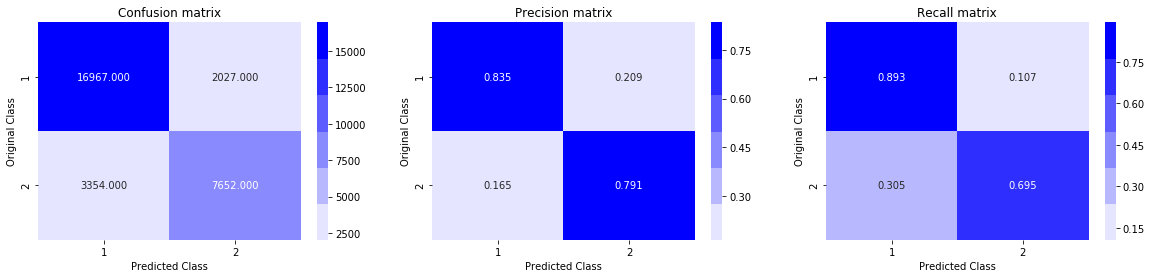

In [229]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

**Max_depth & Min_child_weight**

In [230]:
# hyperparameter tuning for max_depth and min_child_weight
min_logloss = float("Inf")
best_params = None

gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(3, 10)
    for min_child_weight in range(1, 5)
]

for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))

    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight

    # Run CV
    cv_results = xgb.cv(
        params,
        d_train,
        seed=42,
        nfold=10,
        metrics={'logloss'},
        early_stopping_rounds=10
    )
    
    mean_logloss = cv_results['test-logloss-mean'].min()
    boost_rounds = cv_results['test-logloss-mean'].argmin()
    print("\tLogLoss {} for {} rounds".format(mean_logloss, boost_rounds))
    if mean_logloss < min_logloss:
        min_logloss = mean_logloss
        best_params = (max_depth,min_child_weight)   

CV with max_depth=3, min_child_weight=1
	LogLoss 0.627745 for 9 rounds
CV with max_depth=3, min_child_weight=2
	LogLoss 0.627745 for 9 rounds
CV with max_depth=3, min_child_weight=3
	LogLoss 0.627745 for 9 rounds
CV with max_depth=3, min_child_weight=4
	LogLoss 0.627745 for 9 rounds
CV with max_depth=4, min_child_weight=1
	LogLoss 0.6220016 for 9 rounds
CV with max_depth=4, min_child_weight=2
	LogLoss 0.6220016 for 9 rounds
CV with max_depth=4, min_child_weight=3
	LogLoss 0.6220016 for 9 rounds
CV with max_depth=4, min_child_weight=4
	LogLoss 0.6220016 for 9 rounds
CV with max_depth=5, min_child_weight=1
	LogLoss 0.6175955 for 9 rounds
CV with max_depth=5, min_child_weight=2
	LogLoss 0.6175903999999999 for 9 rounds
CV with max_depth=5, min_child_weight=3
	LogLoss 0.6175935000000001 for 9 rounds
CV with max_depth=5, min_child_weight=4
	LogLoss 0.6175949999999999 for 9 rounds
CV with max_depth=6, min_child_weight=1
	LogLoss 0.6139163 for 9 rounds
CV with max_depth=6, min_child_weight=2
	

In [231]:
# best max_depth and min_child_weight
print("Best params: {}, {}".format(best_params[0], best_params[1]))

Best params: 9, 1


**Subsample & Colsample**

In [233]:
# hyperparameter tuning for subsample and colsample
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10 for i in range(6,10)]
    for colsample in [i/10 for i in range(6,10)]
]

min_logloss = float("Inf")
best_params = None

for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))

    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample

    # Run CV
    cv_results = xgb.cv(
        params,
        d_train,
        seed=42,
        nfold=10,
        metrics={'logloss'},
        early_stopping_rounds=10
    )

    # Update best score
    mean_logloss = cv_results['test-logloss-mean'].min()
    boost_rounds = cv_results['test-logloss-mean'].argmin()
    print("\tLogLoss {} for {} rounds".format(mean_logloss, boost_rounds))
    if mean_logloss < min_logloss:
        min_logloss = mean_logloss
        best_params = (subsample,colsample)

# Best subsample and colsample 
print("Best params: {}, {}".format(best_params[0], best_params[1]))

CV with subsample=0.9, colsample=0.9
	LogLoss 0.6088534999999999 for 9 rounds
CV with subsample=0.9, colsample=0.8
	LogLoss 0.6095845999999999 for 9 rounds
CV with subsample=0.9, colsample=0.7
	LogLoss 0.6108140999999999 for 9 rounds
CV with subsample=0.9, colsample=0.6
	LogLoss 0.6121133000000001 for 9 rounds
CV with subsample=0.8, colsample=0.9
	LogLoss 0.6091206 for 9 rounds
CV with subsample=0.8, colsample=0.8
	LogLoss 0.6097758000000001 for 9 rounds
CV with subsample=0.8, colsample=0.7
	LogLoss 0.6110788 for 9 rounds
CV with subsample=0.8, colsample=0.6
	LogLoss 0.612242 for 9 rounds
CV with subsample=0.7, colsample=0.9
	LogLoss 0.6092816999999999 for 9 rounds
CV with subsample=0.7, colsample=0.8
	LogLoss 0.6099989000000001 for 9 rounds
CV with subsample=0.7, colsample=0.7
	LogLoss 0.611212 for 9 rounds
CV with subsample=0.7, colsample=0.6
	LogLoss 0.6124498 for 9 rounds
CV with subsample=0.6, colsample=0.9
	LogLoss 0.6094925000000001 for 9 rounds
CV with subsample=0.6, colsample=

**Gamma**

In [234]:
# hyperparameter tuning for gamma
min_logloss = float("Inf")
best_params = None

gridsearch_params=[gamma
    for gamma in [i/10.0 for i in range(0,5)]]

for gamma in gridsearch_params:
    print("CV with gamma={}".format(gamma))

    # We update our parameters
    params['gamma'] = gamma

    # Run and time CV
    cv_results = xgb.cv(
            params,
            d_train,
            seed=42,
            nfold=10,
            metrics=['logloss'],
            early_stopping_rounds=10
          )

    # Update best score
    mean_logloss = cv_results['test-logloss-mean'].min()
    boost_rounds = cv_results['test-logloss-mean'].argmin()
    print("\tLogLoss {} for {} rounds".format(mean_logloss, boost_rounds))
    if mean_logloss < min_logloss:
        min_logloss = mean_logloss
        best_params = gamma

# Best hyperparameter gamma 
print("Best params: {}".format(best_params))

CV with gamma=0.0
	LogLoss 0.6127324 for 9 rounds
CV with gamma=0.1
	LogLoss 0.612734 for 9 rounds
CV with gamma=0.2
	LogLoss 0.6127282999999999 for 9 rounds
CV with gamma=0.3
	LogLoss 0.6127275000000001 for 9 rounds
CV with gamma=0.4
	LogLoss 0.6127199000000001 for 9 rounds
Best params: 0.4


**Alpha**

In [235]:
# hyperparameter tuning for reg_alpha
min_logloss = float("Inf")
best_params = None


for reg_alpha in [1e-5, 1e-2, 0.1, 1, 100]:
    print("CV with reg_alpha={}".format(reg_alpha))

    # We update our parameters
    params['reg_alpha'] = reg_alpha

    # Run and time CV
    cv_results = xgb.cv(
            params,
            d_train,
            seed=42,
            nfold=10,
            metrics=['logloss'],
            early_stopping_rounds=10
          )

    # Update best score
    mean_logloss = cv_results['test-logloss-mean'].min()
    boost_rounds = cv_results['test-logloss-mean'].argmin()
    print("\tLogLoss {} for {} rounds".format(mean_logloss, boost_rounds))
    if mean_logloss < min_logloss:
        min_logloss = mean_logloss
        best_params = reg_alpha

# best reg_alpha        
print("Best params: {}".format(best_params))

CV with reg_alpha=1e-05
	LogLoss 0.6127199000000001 for 9 rounds
CV with reg_alpha=0.01
	LogLoss 0.6127222999999999 for 9 rounds
CV with reg_alpha=0.1
	LogLoss 0.6127773000000001 for 9 rounds
CV with reg_alpha=1
	LogLoss 0.6131814999999999 for 9 rounds
CV with reg_alpha=100
	LogLoss 0.6264904 for 9 rounds
Best params: 1e-05


**N_estimators**

In [236]:
# hyperparameter tuning for number of estimators
min_logloss = float("Inf")
best_params = None

for n_estimators in [80, 95, 100, 140, 175, 250, 400, 600, 700, 900]:
    print("CV with n_estimators={}".format(n_estimators))

    # We update our parameters
    params['n_estimators'] = n_estimators

    # Run and time CV
    cv_results = xgb.cv(
            params,
            d_train,
            seed=42,
            nfold=10,
            metrics=['logloss'],
            early_stopping_rounds=10
          )

    # Update best score
    mean_logloss = cv_results['test-logloss-mean'].min()
    boost_rounds = cv_results['test-logloss-mean'].argmin()
    print("\tLogLoss {} for {} rounds".format(mean_logloss, boost_rounds))
    if mean_logloss < min_logloss:
        min_logloss = mean_logloss
        best_params = n_estimators
# Best n_estimators
print("Best params: {}".format(best_params))

CV with n_estimators=80
	LogLoss 0.6264904 for 9 rounds
CV with n_estimators=95
	LogLoss 0.6264904 for 9 rounds
CV with n_estimators=100
	LogLoss 0.6264904 for 9 rounds
CV with n_estimators=140
	LogLoss 0.6264904 for 9 rounds
CV with n_estimators=175
	LogLoss 0.6264904 for 9 rounds
CV with n_estimators=250
	LogLoss 0.6264904 for 9 rounds
CV with n_estimators=400
	LogLoss 0.6264904 for 9 rounds
CV with n_estimators=600
	LogLoss 0.6264904 for 9 rounds
CV with n_estimators=700
	LogLoss 0.6264904 for 9 rounds
CV with n_estimators=900
	LogLoss 0.6264904 for 9 rounds
Best params: 80


**Final model with all the tuned hyperparamters**

In [241]:
# Hyperparameter tuned model with best hyperparameters found using CV and reduced test log-loss.

import xgboost as xgb
params= {}

params['n_estimators'] = 80
params['min_child_weight'] = 3
params['subsample'] = 0.9
params['colsample_bytree'] = 0.8
params['gamma'] = 0.4
params['reg_alpha'] = 1e-05
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.01
params['max_depth'] = 6

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 500, watchlist, early_stopping_rounds=20, verbose_eval=10)


xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.68839	valid-logloss:0.688465
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.64627	valid-logloss:0.646884
[20]	train-logloss:0.61078	valid-logloss:0.611982
[30]	train-logloss:0.581092	valid-logloss:0.582811
[40]	train-logloss:0.555159	valid-logloss:0.557367
[50]	train-logloss:0.532614	valid-logloss:0.535271
[60]	train-logloss:0.513063	valid-logloss:0.516129
[70]	train-logloss:0.496036	valid-logloss:0.499474
[80]	train-logloss:0.48108	valid-logloss:0.484926
[90]	train-logloss:0.467687	valid-logloss:0.471944
[100]	train-logloss:0.455906	valid-logloss:0.460505
[110]	train-logloss:0.445196	valid-logloss:0.450192
[120]	train-logloss:0.435902	valid-logloss:0.441312
[130]	train-logloss:0.427498	valid-logloss:0.433261
[140]	train-logloss:0.420062	valid-logloss:0.42618
[150]	train-logloss:0.41352	valid-logloss:0.419975
[160]	train-logloss:0.407488	valid

Total number of data points : 30000


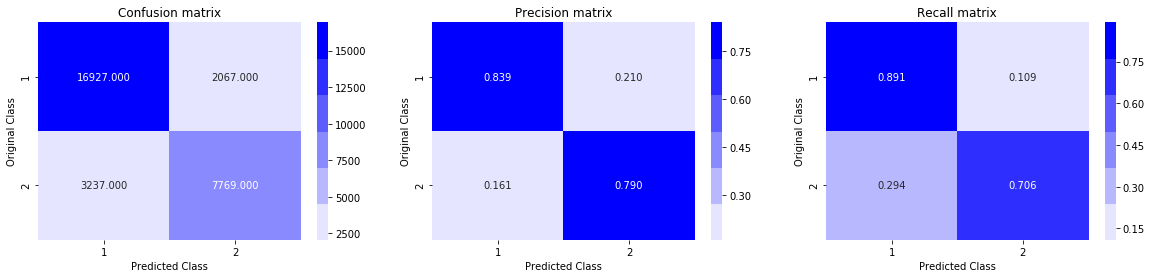

In [242]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

### Conclusion

After hyperparameter tuning of Xgboost we reduced the log-loss. The hyperparameter is being optimized by observing the 
test logloss and picking the best hyperparamter for our xgboost model.